## Import Libraries

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import graphviz

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score 


## Data preprocessing

In [2]:
train_path = r'C:\Users\iamkh\Artificial Intelligence\ImageDataset\train'
test_path = r'C:\Users\iamkh\Artificial Intelligence\ImageDataset\test'

In [3]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder
    
    print(folder)

Normal
Sick


Normal


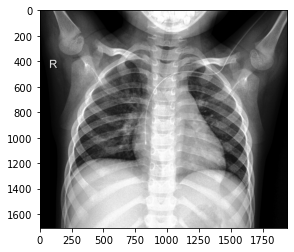

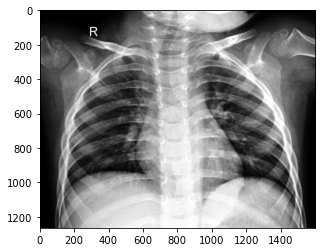

Sick


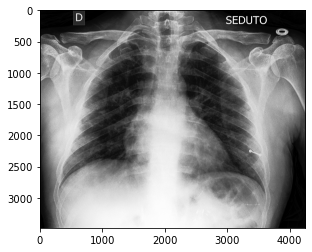

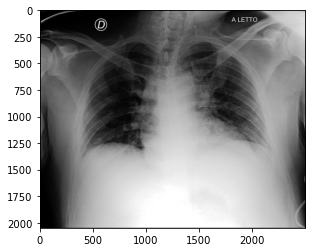

In [4]:
# covert the image to pixel
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder
    
    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

In [8]:
from tensorflow.keras.utils import load_img, img_to_array
from numpy import expand_dims

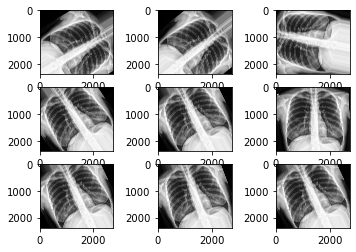

In [9]:
# Data Augmentation
img = load_img(r"C:\Users\iamkh\Artificial Intelligence\ImageDataset\train\Normal\N2.jpg")
# convert to numpy array
data = img_to_array(img)
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)

iterator = datagen.flow(samples, batch_size=1)
for i in range(9):
 plt.subplot(330 + 1 + i)
 batch = iterator.next()
 image = batch[0].astype('uint8')
 plt.imshow(image)

plt.show()

In [10]:
def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path=path+"/"+folder

        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            img_arr=cv2.resize(img_arr, size)
            data.append(img_arr)
            
    return data

In [11]:
size = (224,224)

train = imagearray(train_path, size)
test = imagearray(test_path, size)

In [12]:
#Normalization
x_train = np.array(train)
x_test = np.array(test)

In [13]:
x_train = x_train/255.0
x_test = x_test/255.0

In [14]:
#define target variables
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 32,
                                          class_mode = class_mode)
    return classes

In [15]:
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')

Found 42 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [16]:
y_train = train_class.classes
y_test = test_class.classes

In [17]:
train_class.class_indices

{'Normal': 0, 'Sick': 1}

In [18]:
y_train.shape, y_test.shape

((42,), (18,))

## VGG19 Model

In [19]:
vgg = VGG19(input_shape = (224,224, 3), weights = 'imagenet', include_top = False)

In [20]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

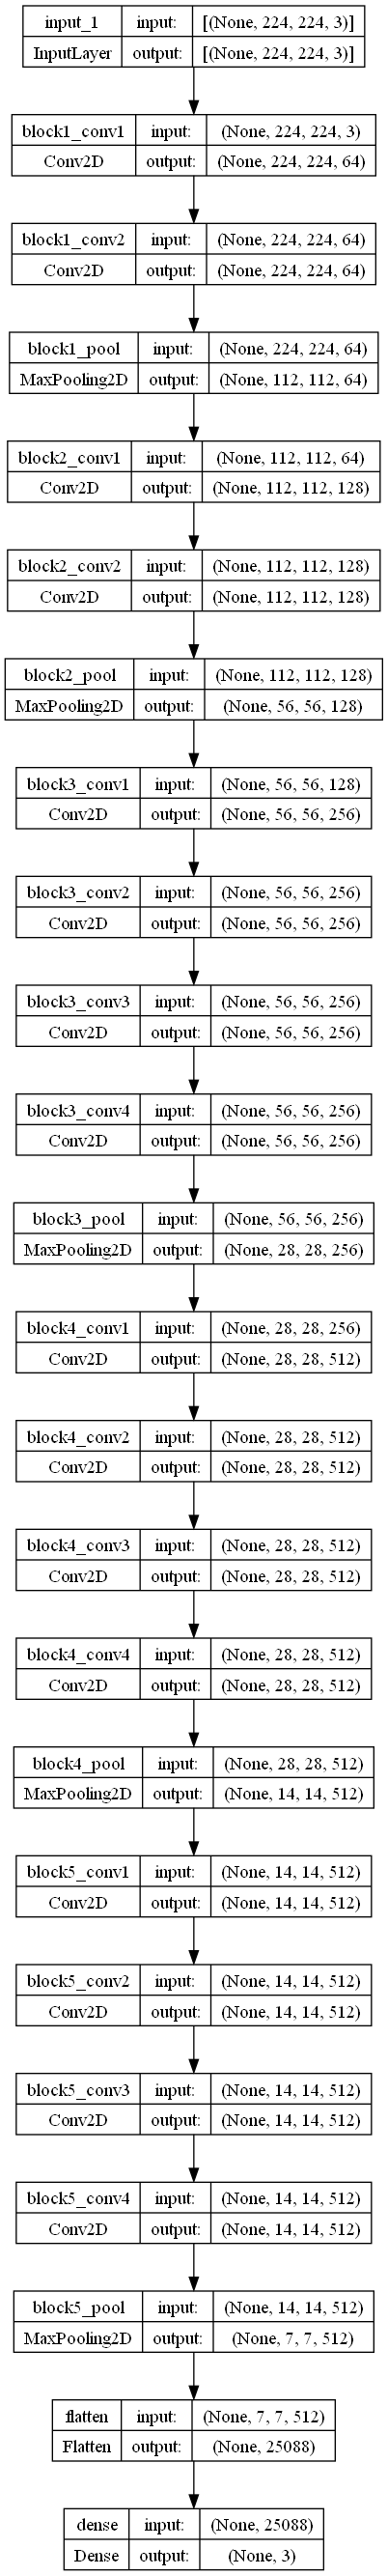

In [21]:
plot_model(model=model, show_shapes=True)

In [22]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)

In [35]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 5, callbacks=[early_stop], batch_size = 32,
                    shuffle=True)

Epoch 1/5
2/2 [==============================] - 34s 16s/step - loss: 0.0291 - accuracy: 0.9762 - val_loss: 0.1911 - val_accuracy: 0.9444
Epoch 2/5
2/2 [==============================] - 35s 16s/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.1351 - val_accuracy: 0.9444
Epoch 3/5
2/2 [==============================] - 34s 16s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0978 - val_accuracy: 0.9444
Epoch 4/5
2/2 [==============================] - 35s 16s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.9444
Epoch 5/5
2/2 [==============================] - 34s 16s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0616 - val_accuracy: 0.9444


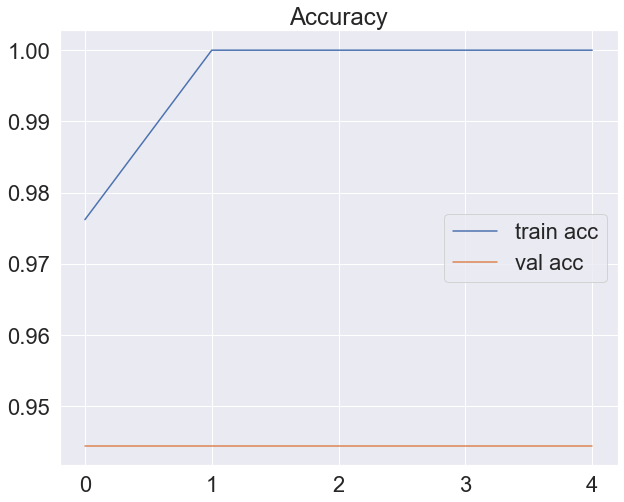

In [36]:
#Visualization
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

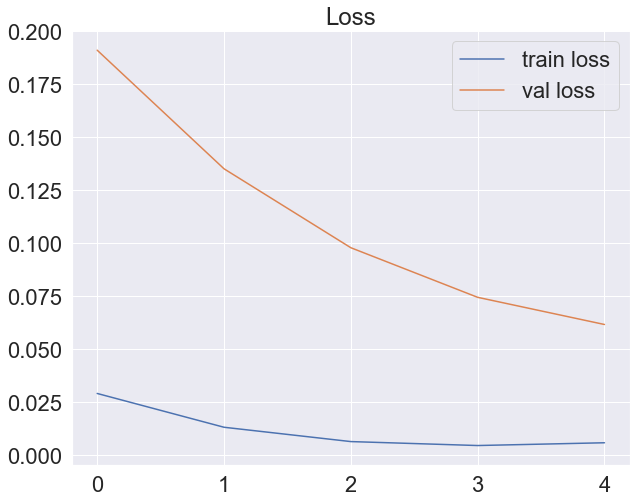

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

## Model Evaluation

In [38]:
model.evaluate(x_test, y_test, batch_size=32)

1/1 [==============================] - 10s 10s/step - loss: 0.0616 - accuracy: 0.9444


[0.061606790870428085, 0.9444444179534912]

In [40]:
y_pred = model.predict(x_test)

1/1 [==============================] - 10s 10s/step


In [41]:
y_pred=np.argmax(y_pred,axis=1)

In [42]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.89      1.00      0.94         8

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18



## Confusion Matrix

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Sick')]

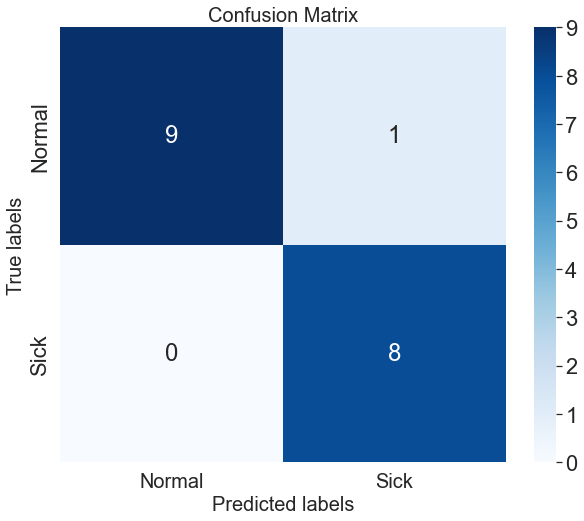

In [43]:
cm = confusion_matrix(y_pred,y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=20); 
ax.xaxis.set_ticklabels(['Normal', 'Sick'], fontsize=20); ax.yaxis.set_ticklabels(['Normal', 'Sick'])

In [44]:
f1_score(y_test, y_pred, average='micro')

0.9444444444444444

In [45]:
recall_score(y_test, y_pred, average='weighted')

0.9444444444444444

In [46]:
precision_score(y_test, y_pred, average='micro')

0.9444444444444444

In [47]:
model.save("classification_VGG19_model.h5")